In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
df = pd.read_csv('japan_heart_attack_dataset.csv')
print(df.columns)

Index(['Age', 'Gender', 'Region', 'Smoking_History', 'Diabetes_History',
       'Hypertension_History', 'Cholesterol_Level', 'Physical_Activity',
       'Diet_Quality', 'Alcohol_Consumption', 'Stress_Levels', 'BMI',
       'Heart_Rate', 'Systolic_BP', 'Diastolic_BP', 'Family_History',
       'Heart_Attack_Occurrence', 'Extra_Column_1', 'Extra_Column_2',
       'Extra_Column_3', 'Extra_Column_4', 'Extra_Column_5', 'Extra_Column_6',
       'Extra_Column_7', 'Extra_Column_8', 'Extra_Column_9', 'Extra_Column_10',
       'Extra_Column_11', 'Extra_Column_12', 'Extra_Column_13',
       'Extra_Column_14', 'Extra_Column_15'],
      dtype='object')


In [3]:
# List the names of the extra columns you want to remove
extra_columns = [f"Extra_Column_{i}" for i in range(1, 16)]

# Drop the extra columns from the dataframe
df = df.drop(columns=extra_columns)

# Check if the columns have been removed
print(df.columns)

Index(['Age', 'Gender', 'Region', 'Smoking_History', 'Diabetes_History',
       'Hypertension_History', 'Cholesterol_Level', 'Physical_Activity',
       'Diet_Quality', 'Alcohol_Consumption', 'Stress_Levels', 'BMI',
       'Heart_Rate', 'Systolic_BP', 'Diastolic_BP', 'Family_History',
       'Heart_Attack_Occurrence'],
      dtype='object')


In [4]:
df_raw = df.copy()

In [5]:
# Check for missing values
missing_data = df.isnull().sum()

# For simplicity, let's fill missing values with the median for numerical columns
# and the most frequent value for categorical columns

df_cleaned = df.copy()

# Fill missing values in numerical columns with the median
for col in df_cleaned.select_dtypes(include=['float64', 'int64']).columns:
    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())

# Fill missing values in categorical columns with the most frequent value
for col in df_cleaned.select_dtypes(include=['object']).columns:
    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])

# Check the cleaned data for missing values again
print(df_cleaned.isnull().sum())


Age                        0
Gender                     0
Region                     0
Smoking_History            0
Diabetes_History           0
Hypertension_History       0
Cholesterol_Level          0
Physical_Activity          0
Diet_Quality               0
Alcohol_Consumption        0
Stress_Levels              0
BMI                        0
Heart_Rate                 0
Systolic_BP                0
Diastolic_BP               0
Family_History             0
Heart_Attack_Occurrence    0
dtype: int64


In [6]:
from scipy import stats

print(f"Shape before outlier removal: {df_cleaned.shape}")
# Calculate Z-scores for numerical columns
z_scores = stats.zscore(df_cleaned.select_dtypes(include=['float64', 'int64']))

# Set a threshold for Z-score to filter out outliers
threshold = 3
df_cleaned = df_cleaned[(z_scores < threshold).all(axis=1)]

# Check shape after removing outliers
print(f"Shape after outlier removal: {df_cleaned.shape}")

Shape before outlier removal: (30000, 17)
Shape after outlier removal: (29807, 17)


Class distribution:
Heart_Attack_Occurrence
No     27036
Yes     2964
Name: count, dtype: int64


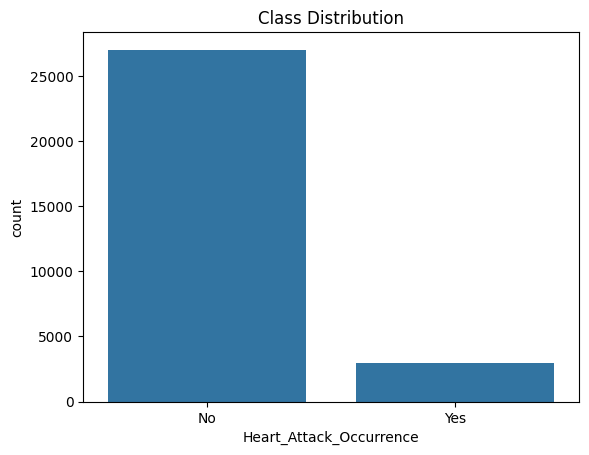

Terjadi Imbalance pada Dataset, Sehingga akan dilakukan SMOTE


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check class distribution
print("Class distribution:")
print(df['Heart_Attack_Occurrence'].value_counts())

# Visualize class distribution
sns.countplot(x=df['Heart_Attack_Occurrence'])
plt.title("Class Distribution")
plt.show()

print("Terjadi Imbalance pada Dataset, Sehingga akan dilakukan SMOTE")

In [8]:
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE

# Define categorical and numerical columns
categorical_cols = ['Gender', 'Region', 'Smoking_History', 'Diabetes_History', 'Hypertension_History', 
                    'Physical_Activity', 'Diet_Quality', 'Alcohol_Consumption', 'Family_History']
numerical_cols = ['Age', 'Cholesterol_Level', 'BMI', 'Heart_Rate', 'Systolic_BP', 'Diastolic_BP', 'Stress_Levels']

# Encode categorical columns
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df_encoded = df_cleaned.copy()
df_encoded[categorical_cols] = encoder.fit_transform(df_encoded[categorical_cols])

# Define features and target variable
X = df_encoded.drop(columns=['Heart_Attack_Occurrence'])
y = df_encoded['Heart_Attack_Occurrence']


In [9]:
print(df_encoded.isnull().sum())

Age                        0
Gender                     0
Region                     0
Smoking_History            0
Diabetes_History           0
Hypertension_History       0
Cholesterol_Level          0
Physical_Activity          0
Diet_Quality               0
Alcohol_Consumption        0
Stress_Levels              0
BMI                        0
Heart_Rate                 0
Systolic_BP                0
Diastolic_BP               0
Family_History             0
Heart_Attack_Occurrence    0
dtype: int64


In [10]:
# Apply SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Adjust strategy if needed
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a new DataFrame with resampled data
df_smote = pd.DataFrame(X_resampled, columns=X.columns)
df_smote['Heart_Attack_Occurrence'] = y_resampled

# Check new class distribution
print("Class distribution after SMOTE:")
print(df_smote['Heart_Attack_Occurrence'].value_counts())


Class distribution after SMOTE:
Heart_Attack_Occurrence
No     26863
Yes    13431
Name: count, dtype: int64


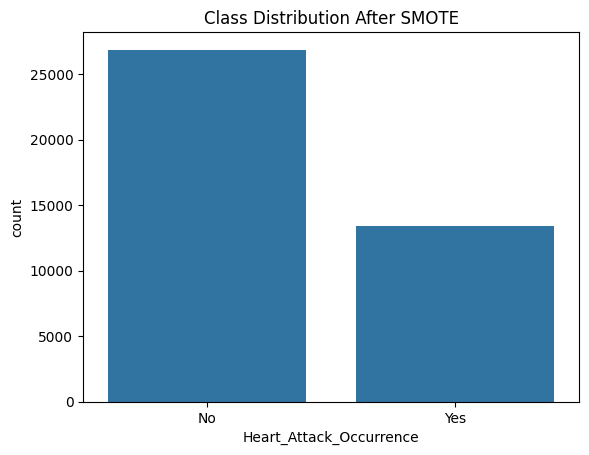

Sekarang data sudah mendingan dari yang sebelumnya


In [11]:
sns.countplot(x=df_smote['Heart_Attack_Occurrence'])
plt.title("Class Distribution After SMOTE")
plt.show()
print("Sekarang data sudah mendingan dari yang sebelumnya")

In [12]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = df_smote.drop(columns=['Heart_Attack_Occurrence'])  # Adjust if your target column has a different name
y = df_smote['Heart_Attack_Occurrence']

# Split into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the shape
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train distribution:\n", y_train.value_counts(normalize=True))
print("y_test distribution:\n", y_test.value_counts(normalize=True))

X_train shape: (32235, 16)
X_test shape: (8059, 16)
y_train distribution:
 Heart_Attack_Occurrence
No     0.666667
Yes    0.333333
Name: proportion, dtype: float64
y_test distribution:
 Heart_Attack_Occurrence
No     0.666708
Yes    0.333292
Name: proportion, dtype: float64


In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Define the columns
categorical_cols = ['Gender', 'Region', 'Smoking_History', 'Diabetes_History', 'Hypertension_History', 
                    'Physical_Activity', 'Diet_Quality', 'Alcohol_Consumption', 'Family_History']
numerical_cols = ['Age', 'Cholesterol_Level', 'BMI', 'Heart_Rate', 'Systolic_BP', 'Diastolic_BP', 'Stress_Levels']

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean (if any)
            ('scaler', StandardScaler())  # Scale numerical features
        ]), numerical_cols),
        
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing categorical values
            ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))  # Encode categorical data
        ]), categorical_cols)
    ])


In [14]:
from imblearn.over_sampling import SMOTE

# Step 1: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Preprocess the training data (scaling, encoding) - keep original DataFrame format
X_train_processed = preprocessor.fit_transform(X_train)

# Convert the preprocessed data back into DataFrame for consistency
X_train_processed_df = pd.DataFrame(X_train_processed, columns=preprocessor.get_feature_names_out())

# Step 3: Apply SMOTE to the training data (balance the classes)
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed_df, y_train)

# Step 4: Preprocess the test data (only transform, no fitting)
X_test_processed = preprocessor.transform(X_test)

# Check the shapes after preprocessing to ensure it's correct
print(f"X_train_processed shape: {X_train_resampled.shape}")
print(f"X_test_processed shape: {X_test_processed.shape}")

# Step 5: Check class distribution after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

# Step 6: Convert to DataFrame (optional, for easier model evaluation)
X_train_df = pd.DataFrame(X_train_resampled, columns=preprocessor.get_feature_names_out())
X_test_df = pd.DataFrame(X_test_processed, columns=preprocessor.get_feature_names_out())

# Check the dataframes
print(X_train_df.head())
print(X_test_df.head())


X_train_processed shape: (32256, 16)
X_test_processed shape: (8059, 16)
Class distribution after SMOTE:
Heart_Attack_Occurrence
No     21504
Yes    10752
Name: count, dtype: int64
   num__Age  num__Cholesterol_Level  num__BMI  num__Heart_Rate  \
0 -0.582958                1.627818 -0.789376        -1.059690   
1 -0.133316                1.987960  0.183660        -0.011676   
2 -1.538447               -0.101774 -0.573587        -0.552515   
3  1.496636                0.588930 -1.216561        -0.881196   
4 -0.358137                0.650294 -0.448732         0.780252   

   num__Systolic_BP  num__Diastolic_BP  num__Stress_Levels  cat__Gender  \
0          0.164063          -0.623904           -0.822274       4206.0   
1         -1.230026          -1.470434            0.994251       4206.0   
2         -0.227257           0.644661           -1.425717       4206.0   
3          1.148571          -0.543617           -2.428778          0.0   
4         -0.470147           1.290180          

Model: Logistic Regression
Accuracy: 0.48194565082516444
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.51      0.57      5359
           1       0.30      0.42      0.35      2700

    accuracy                           0.48      8059
   macro avg       0.47      0.47      0.46      8059
weighted avg       0.53      0.48      0.50      8059



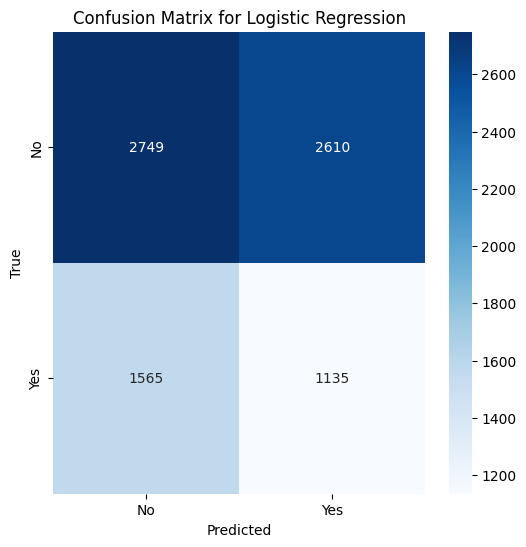



Model: Random Forest
Accuracy: 0.6673284526616206
Classification Report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80      5359
           1       1.00      0.01      0.01      2700

    accuracy                           0.67      8059
   macro avg       0.83      0.50      0.41      8059
weighted avg       0.78      0.67      0.54      8059



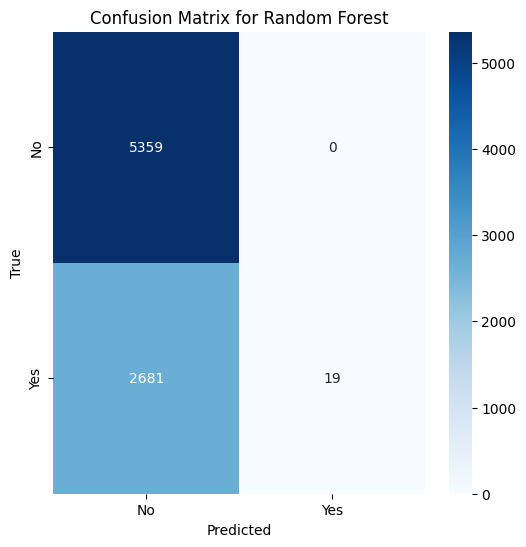



Model: SVM
Accuracy: 0.6649708400545974
Classification Report:
              precision    recall  f1-score   support

           0       0.66      1.00      0.80      5359
           1       1.00      0.00      0.00      2700

    accuracy                           0.66      8059
   macro avg       0.83      0.50      0.40      8059
weighted avg       0.78      0.66      0.53      8059



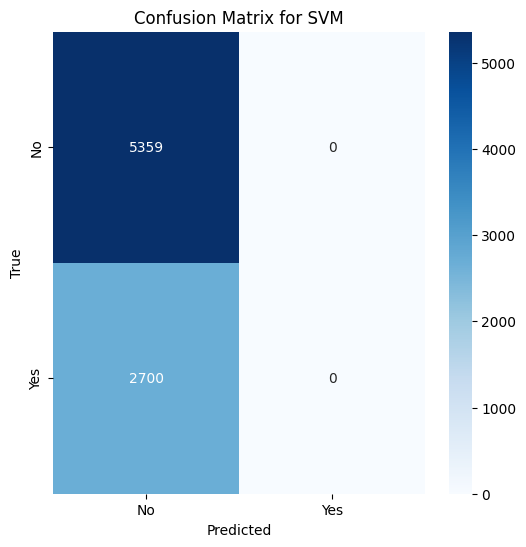



Model: XGBoost
Accuracy: 0.6691897257724283
Classification Report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80      5359
           1       0.85      0.02      0.03      2700

    accuracy                           0.67      8059
   macro avg       0.76      0.51      0.42      8059
weighted avg       0.73      0.67      0.54      8059



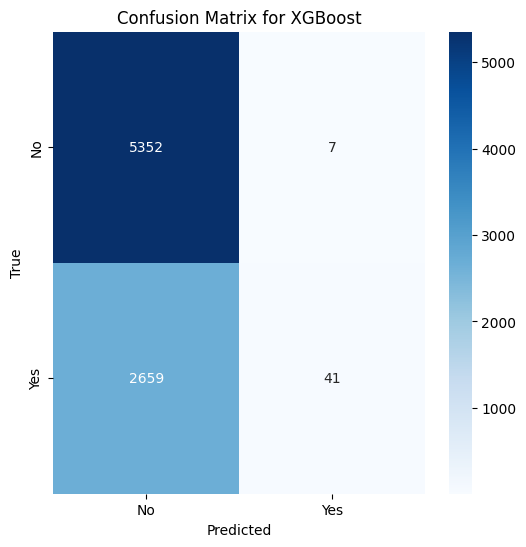

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import numpy as np

# Initialize the models
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced',max_iter=2000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

# Initialize a dictionary to store the results
model_results = {}

# Map the target labels from 'Yes'/'No' to 1/0 for confusion matrix and model
label_mapping = {'No': 0, 'Yes': 1}

# Convert the target labels 'No'/'Yes' to numeric labels for both training and testing sets
y_train_resampled_numeric = np.array([label_mapping[label] for label in y_train_resampled])
y_test_numeric = np.array([label_mapping[label] for label in y_test])


X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=preprocessor.get_feature_names_out())
X_test_processed_df = pd.DataFrame(X_test_processed, columns=preprocessor.get_feature_names_out())
# Train each model and evaluate performance
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_resampled_df, y_train_resampled_numeric)
    y_pred = model.predict(X_test_processed_df)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test_numeric, y_pred)
    report = classification_report(y_test_numeric, y_pred, zero_division=1)
    
    # Store the results
    model_results[model_name] = {
        'accuracy': accuracy,
        'report': report
    }
    
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy}")
    print("Classification Report:")
    print(report)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test_numeric, y_pred)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print("\n")

Karena 3 model terakhir sangat bias, maka saya terpaksa memilih model pertama untuk dideploy


In [18]:
import joblib

# Assuming 'Logistic Regression' is your best model
best_model = models['Logistic Regression']  # Adjust this if needed

# Save only the trained model
with open("model.pkl", "wb") as file:
    joblib.dump(best_model, file)

print("✅ Model saved correctly as 'model.pkl'")

✅ Model saved correctly as 'model.pkl'


In [20]:
with open("model.pkl", "rb") as file:
    model = joblib.load(file)

print(f"Loaded model type: {type(model)}")

# Check if the model has a `predict` method
if hasattr(model, "predict"):
    print("✅ Model is ready for predictions.")
else:
    print("❌ Model is not a valid predictor. Re-save it correctly.")

Loaded model type: <class 'sklearn.linear_model._logistic.LogisticRegression'>
✅ Model is ready for predictions.


In [21]:
print(model)

LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)
